In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [7]:
tweets = pd.read_csv('./data/train.csv', encoding='utf-8')
tweets.loc[:,'keyword'] = tweets.loc[:,'keyword'].str.replace("%20", " ")
tweets.sample(10)

,id,keyword,location,text,target
6044,8639,seismic,NaN,The Art World's Seismic Shift Back to the Oddb...,0
3177,4562,emergency plan,"Calgary, Alberta, Canada",.@CityofCalgary activates emergency plan amid ...,1
6115,8729,sinking,NaN,Sinking carb consultative assembly plans could...,0
697,1004,blazing,NaN,I'm crazy enough to run in 95 degree mid-day h...,0
1453,2096,casualty,Hartford London Hong Kong,Conning Builds Strong Case for Portfolio #Dive...,0
5952,8503,screaming,NaN,@BizzleMahomie SCREAMING,0
6337,9059,structural failure,USA,Virgin galactic crash: early unlocking of brak...,1
4938,7036,mayhem,WORLDWIDE-BOSTON,@RaynbowAffair Editor In Chief @DiamondKesawn ...,0
2007,2883,damage,Somewhere in the Canada,Nine inmates charged with causing damage in Ca...,1
1500,2163,catastrophic,NaN,catastrophic-fallen-angel: reveillertm: macabr...,0


In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## ¿Cuántas keywords únicas?

In [9]:
len(tweets.keyword.unique())

222

In [13]:
keywords_grouped = tweets.groupby(['keyword', 'target']).agg({'keyword':['count']})
keywords_level1 = keywords_grouped.columns.get_level_values(1)

print(keywords_level1)

keywords_grouped.columns = keywords_level1
keywords_grouped.reset_index(inplace=True)
keywords_grouped.head(10)

Index(['count'], dtype='object')


,keyword,target,count
0,ablaze,0,23
1,ablaze,1,13
2,accident,0,11
3,accident,1,24
4,aftershock,0,34
5,airplane accident,0,5
6,airplane accident,1,30
7,ambulance,0,18
8,ambulance,1,20
9,annihilated,0,23


In [14]:
keywords_total_count = tweets.groupby(['keyword']).agg({'keyword': ['count']})
keywords_total_count.columns = 'total_' + keywords_total_count.columns.get_level_values(1)
keywords_total_count.reset_index(inplace=True)
keywords_total_count.head(10)

,keyword,total_count
0,ablaze,36
1,accident,35
2,aftershock,34
3,airplane accident,35
4,ambulance,38
5,annihilated,34
6,annihilation,29
7,apocalypse,32
8,armageddon,42
9,army,34


In [15]:
keywords = keywords_grouped.merge(keywords_total_count, left_on='keyword', right_on='keyword', how='left')
keywords.loc[:,'percentage_count'] = (keywords.loc[:, 'count'] / keywords.loc[:, 'total_count']) * 100
keywords.head(10)

,keyword,target,count,total_count,percentage_count
0,ablaze,0,23,36,63.888889
1,ablaze,1,13,36,36.111111
2,accident,0,11,35,31.428571
3,accident,1,24,35,68.571429
4,aftershock,0,34,34,100.000000
5,airplane accident,0,5,35,14.285714
6,airplane accident,1,30,35,85.714286
7,ambulance,0,18,38,47.368421
8,ambulance,1,20,38,52.631579
9,annihilated,0,23,34,67.647059


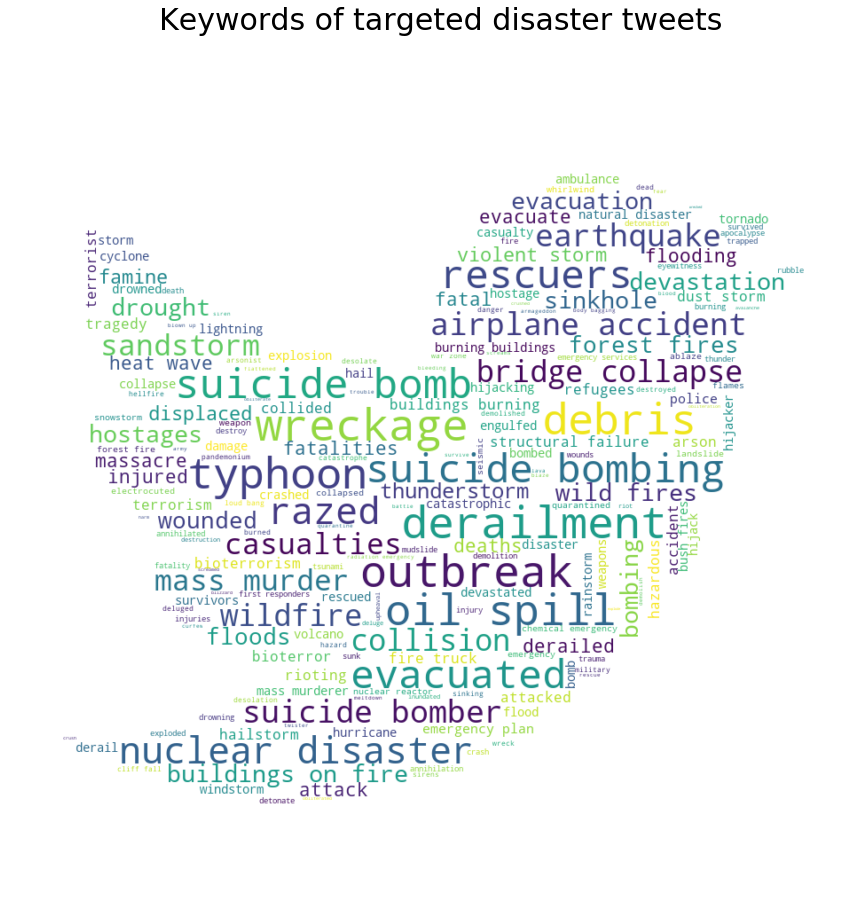

In [16]:
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val

keywords_count = tweets.loc[tweets['target'] == 1].keyword.value_counts()
keywords_count.index = keywords_count.index.map(str)


mask = np.array(Image.open("./img/twitter_black.png"))
mask_transformed = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

for i in range(len(mask)):
    mask_transformed[i] = list(map(transform_format, mask[i]))

wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white", mask=mask_transformed)
wordcloud.generate_from_frequencies(keywords_count)

plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Keywords of targeted disaster tweets", fontsize=30, pad=40)
plt.axis("off")
plt.show()

## Keywords más acertadas, tomando como >= 90% targeted

In [17]:
targeted_keywords = keywords.loc[(keywords['percentage_count'] >= 90) & (keywords['target'] == 1)]
targeted_keywords

,keyword,target,count,total_count,percentage_count
64,bombing,1,27,29,93.103448
123,debris,1,37,37,100.000000
138,derailment,1,39,39,100.000000
292,nuclear disaster,1,31,34,91.176471
302,oil spill,1,37,38,97.368421
304,outbreak,1,39,40,97.500000
330,rescuers,1,32,35,91.428571
368,suicide bomb,1,32,35,91.428571
370,suicide bomber,1,30,31,96.774194
372,suicide bombing,1,32,33,96.969697


Text(0,0.5,'Keyword')

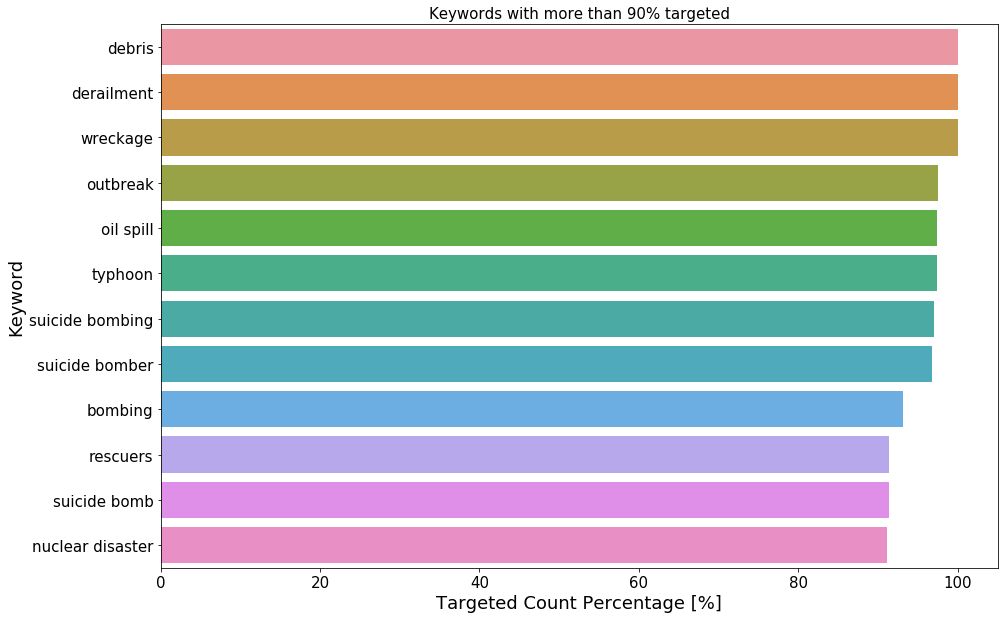

In [18]:
targeted_keywords = targeted_keywords.sort_values(['percentage_count'], ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=targeted_keywords['percentage_count'], y=targeted_keywords['keyword'],
               orient='h')

g.set_title('Keywords with more than 90% targeted', fontsize=15)
g.set_xlabel('Targeted Count Percentage [%]', fontsize=18)
g.set_ylabel('Keyword', fontsize=18)

## Keywords menos acertadas, tomando como >= 90% not targeted

In [19]:
not_targeted_keywords = keywords.loc[(keywords['percentage_count'] >= 90) & (keywords['target'] == 0)]
not_targeted_keywords

# frequency >= 10

,keyword,target,count,total_count,percentage_count
4,aftershock,0,34,34,100.000000
37,blazing,0,33,34,97.058824
41,blew up,0,31,33,93.939394
43,blight,0,30,32,93.750000
49,bloody,0,32,35,91.428571
53,body bag,0,32,33,96.969697
57,body bags,0,40,41,97.560976
95,collide,0,31,34,91.176471
163,drown,0,29,32,90.625000
173,electrocute,0,31,32,96.875000


Text(0,0.5,'Keyword')

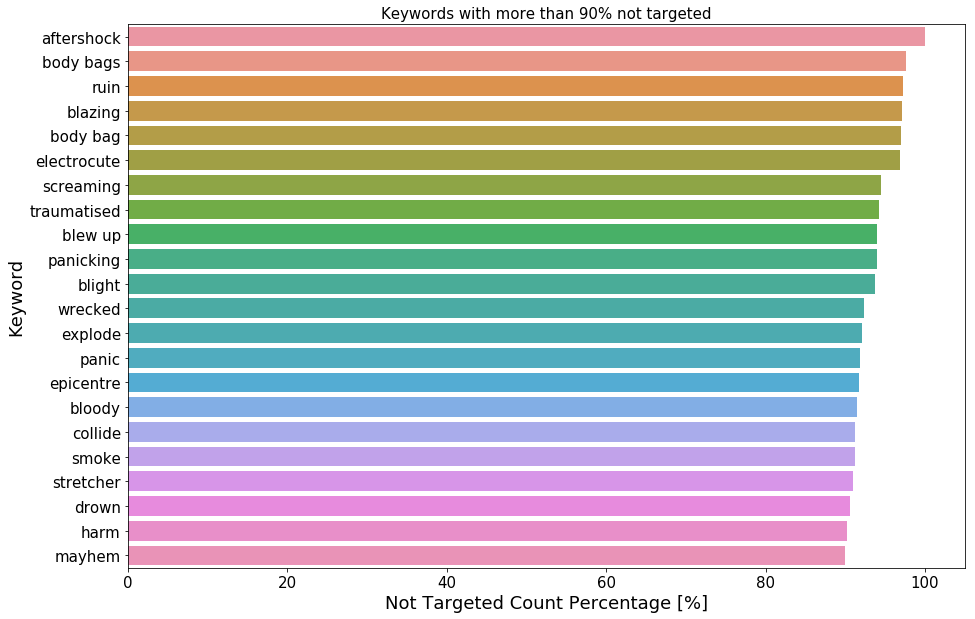

In [20]:
not_targeted_keywords = not_targeted_keywords.sort_values(['percentage_count'], ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=not_targeted_keywords['percentage_count'], y=not_targeted_keywords['keyword'],
               orient='h')

g.set_title('Keywords with more than 90% not targeted', fontsize=15)
g.set_xlabel('Not Targeted Count Percentage [%]', fontsize=18)
g.set_ylabel('Keyword', fontsize=18)

## Keyword Length

In [21]:
keyword_tweets = tweets.dropna(subset=['keyword']).copy()
keyword_tweets['keyword_length'] = keyword_tweets['keyword'].apply(len)
keyword_tweets

,id,keyword,location,text,target,keyword_length
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,6
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,6
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,6
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,6
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,6
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0,6
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,6
38,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,6
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,0,6
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,6


In [22]:
keyword_length = keyword_tweets.groupby(['target'])\
                .agg({'keyword_length': ['count','mean','min','max']})
keyword_length.columns = keyword_length.columns.get_level_values(0) + \
                '_' + keyword_length.columns.get_level_values(1)
keyword_length.reset_index(inplace=True)
keyword_length

,target,keyword_length_count,keyword_length_mean,keyword_length_min,keyword_length_max
0,0,4323,7.993060,4,19
1,1,3229,8.991329,4,19


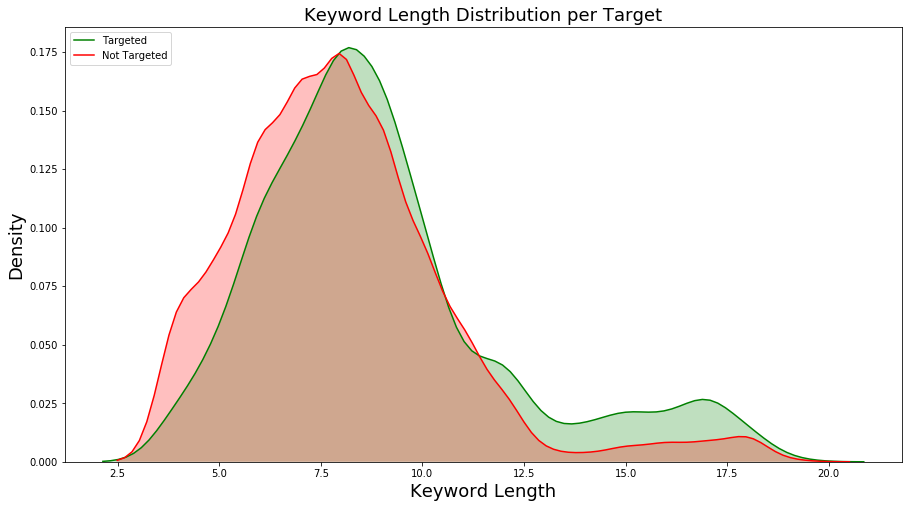

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
g = sns.kdeplot(keyword_tweets.loc[(keyword_tweets['target'] == 1), :]['keyword_length'], 
                color='green',
                label='Targeted',
                shade=True,
               ax= ax)
g = sns.kdeplot(keyword_tweets.loc[(keyword_tweets['target'] == 0), :]['keyword_length'], 
                color='red',
                label='Not Targeted',
                shade=True,
               ax= ax)

g.set_title('Keyword Length Distribution per Target', fontsize=18)
g.set_xlabel('Keyword Length', fontsize=18)
g.set_ylabel('Density', fontsize=18)
g.legend(loc='upper left')